<a href="https://colab.research.google.com/github/jayapat/datascience_projects/blob/main/Fast_ai_Dog_Breed_Classification_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade fastai fastcore timm kaggle pynvml nbdev -qq

     |████████████████████████████████| 549 kB 4.6 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 64 kB 1.1 MB/s 
     |████████████████████████████████| 182 kB 6.3 MB/s 
     |████████████████████████████████| 78 kB 1.6 MB/s 
     |████████████████████████████████| 58 kB 2.7 MB/s 
     |████████████████████████████████| 1.6 MB 11.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from pathlib import Path
base_folder = Path('/content/drive/MyDrive/data')

In [ ]:
data_folder = base_folder/'datasets'/'paddy-disease-classification'
model_folder = base_folder/'models/dl_fall_2022'/'paddy-disease-classification'
archive_folder = base_folder/'archive'
kaggle_api = base_folder/'.kaggle'

In [ ]:
data_folder.mkdir(exist_ok=True, parents=True)
model_folder.mkdir(exist_ok=True, parents=True)
kaggle_api.mkdir(exist_ok=True, parents=True)
archive_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
kaggle_api

PosixPath('/content/drive/MyDrive/data/.kaggle')

In [ ]:
!ls -la '/content/drive/MyDrive/data/.kaggle'

total 1
-rw------- 1 root root 63 Dec  7 05:41 kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/data/.kaggle'

In [ ]:
! chmod 600 '/content/drive/MyDrive/data/.kaggle/kaggle.json'

In [ ]:
!ls -la /content/drive/MyDrive/data/.kaggle

total 1
-rw------- 1 root root 63 Dec  7 05:41 kaggle.json


In [ ]:
from fastai.vision.all import *
from kaggle import api
from fastcore.parallel import *
import timm


In [ ]:
 ! kaggle competitions download -c inclassdlfall22 -p {archive_folder}

inclassdlfall22.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls -la /content/drive/MyDrive/data/archive

total 97630
-rw------- 1 root root 99972387 Dec  5 21:38 inclassdlfall22.zip


In [ ]:
data_file = archive_folder/'inclassdlfall22.zip'

In [ ]:
 # !unzip -q {data_file} -d {data_folder}

In [ ]:
Path.BASE_PATH = data_folder

In [ ]:
data_folder.ls()

(#3) [Path('sample_submission.csv'),Path('test'),Path('train')]

In [ ]:
(data_folder/'train').ls()

(#1) [Path('train/train')]

In [ ]:
train_path = data_folder/'train'
test_path = data_folder/'test'

In [ ]:
train_files = get_image_files(train_path)
test_files = get_image_files(test_path)


In [ ]:
train_files

(#9025) [Path('train/train/0/1004.JPEG'),Path('train/train/0/1124.JPEG'),Path('train/train/0/1319.JPEG'),Path('train/train/0/1323.JPEG'),Path('train/train/0/1041.JPEG'),Path('train/train/0/1516.JPEG'),Path('train/train/0/1465.JPEG'),Path('train/train/0/1423.JPEG'),Path('train/train/0/1161.JPEG'),Path('train/train/0/1107.JPEG')...]

In [ ]:
test_files

(#3929) [Path('test/test/3321.JPEG'),Path('test/test/315.JPEG'),Path('test/test/2968.JPEG'),Path('test/test/2986.JPEG'),Path('test/test/3697.JPEG'),Path('test/test/2989.JPEG'),Path('test/test/3521.JPEG'),Path('test/test/3001.JPEG'),Path('test/test/2833.JPEG'),Path('test/test/295.JPEG')...]

In [ ]:
train_labels = [parent_label(file) for file in train_files]

In [ ]:
pd.Series(train_labels).value_counts()

7    949
9    949
6    943
8    942
0    941
5    940
3    932
1    928
2    921
4    580
dtype: int64

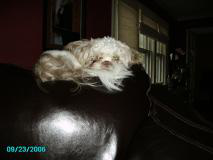

In [ ]:
img = PILImage.create(train_files[0])
img.to_thumb(h = 300)

In [ ]:
img.size

(213, 160)

In [ ]:
def get_img_size(file):
  return PILImage.create(file).size

In [ ]:
from fastcore.parallel import *

In [ ]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms = Resize(size = (480), method = 'squish'),
                   batch_tfms = aug_transforms(size = (256), min_scale = 1)
                   )

In [ ]:
dls = dblock.dataloaders(data_folder/'train', bs = 64)

In [ ]:
import timm

In [ ]:
learn = vision_learner(dls, models.convnext_tiny, metrics = [error_rate, accuracy] , path = model_folder).to_fp16()
#learn = vision_learner(dls, models.resnet34 , metrics = error_rate, path = model_folder).to_fp16()
#learn = vision_learner(dls, models.resnet18 , metrics = error_rate, path = model_folder).to_fp16()
learn.fit_one_cycle(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.523097,0.132878,0.038227,0.961773,11:42
1,0.194082,0.137779,0.034903,0.965097,01:20
2,0.138409,0.124316,0.032687,0.967313,01:21


In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.160001,0.144841,0.041551,0.958449,01:24


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.107695,0.114757,0.032133,0.967867,01:26
1,0.110241,0.125431,0.034349,0.965651,01:27
2,0.088945,0.119512,0.030471,0.969529,01:26
3,0.080129,0.109344,0.031025,0.968975,01:28
4,0.066949,0.111275,0.030471,0.969529,01:26
5,0.051400,0.116414,0.031579,0.968421,01:28
6,0.043199,0.110459,0.026593,0.973407,01:25
7,0.045534,0.111222,0.028809,0.971191,01:21


In [ ]:
sample_submission = pd.read_csv(data_folder/'sample_submission.csv')

In [ ]:
sample_submission.sort_values(by = ['file_names'], inplace = True, ignore_index = True)

In [ ]:
sample_submission 

,file_names,target
0,0.JPEG,7
1,1.JPEG,3
2,10.JPEG,7
3,100.JPEG,2
4,1000.JPEG,2
...,...,...
3924,995.JPEG,6
3925,996.JPEG,4
3926,997.JPEG,0
3927,998.JPEG,4


In [ ]:
test_files = get_image_files(data_folder/'test').sorted()

In [ ]:
test_dl = learn.dls.test_dl(test_files)

In [ ]:
preds, _ = learn.tta(dl = test_dl)

In [ ]:
preds.shape

torch.Size([3929, 10])

In [ ]:
idxs = preds.argmax(dim = 1)

In [ ]:
idxs

TensorBase([7, 2, 0,  ..., 8, 3, 6])

In [ ]:
vocab = np.array(learn.dls.vocab)
vocab

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [ ]:
results = pd.Series(vocab[idxs], name = 'idxs')

In [ ]:
results

0       7
1       2
2       0
3       5
4       3
       ..
3924    7
3925    7
3926    8
3927    3
3928    6
Name: idxs, Length: 3929, dtype: object

In [ ]:
sample_submission['target'] = results

In [ ]:
sample_submission

,file_names,target
0,0.JPEG,7
1,1.JPEG,2
2,10.JPEG,0
3,100.JPEG,5
4,1000.JPEG,3
...,...,...
3924,995.JPEG,7
3925,996.JPEG,7
3926,997.JPEG,8
3927,998.JPEG,3


In [ ]:
sample_submission.to_csv(model_folder/'Nine_sub.csv', index = False)

In [ ]:
! head {model_folder/'Nine_sub.csv'}

file_names,target
0.JPEG,7
1.JPEG,2
10.JPEG,0
100.JPEG,5
1000.JPEG,3
1001.JPEG,5
1002.JPEG,3
1003.JPEG,8
1004.JPEG,8


In [ ]:
comp = 'inclassdlfall22'

In [ ]:
api.competition_submit(model_folder/'Nine_sub.csv', 'Nine_submission', comp)

100%|██████████| 45.0k/45.0k [00:00<00:00, 47.2kB/s]


Successfully submitted to Inclass_DL_Fall_22